# BBM469 - Assignment 3

#### Student no : 21627653
#### Student name : Ali Baran Tasdemir



## Table of Content

[Purpose](#purpose)   
[Data Understanding](#data_understanding)   
[Data Preparation](#data_preparation)   
[Modeling for Clustering](#clusteringmodel)  
[Clustering results](#clustering)    
[Modeling for Classification](#classificationmodel)  
[Evaluation](#evaluation)  
[References](#references)   


## Purpose <a class="anchor" id="purpose"></a>

This assignment aims to diagnose breast cancer by using machine learning techniques with Spark. The main intuition is to learn to use Spark enviroment for a machine learning task. 

The task for the assignment is diagnosing breast cancer by looking features created with breast cells images. And classify and cluster the dataset for diagnose noted as M or B (M = Malignant, B = Benign).

#### Installing Spark

In [0]:
# Installing spark on google colab.

!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [4]:
from google.colab import files
uploaded = files.upload()

Saving data.csv to data.csv


## Data Understanding<a class="anchor" id="data_understanding"></a>



Information of columns

*    id: ID number

*    diagnosis: The diagnosis of breast tissues (M = malignant, B = benign)

*    radius_mean: mean of distances from center to points on the perimeter

*    texture_mean: standard deviation of gray-scale values

*    perimeter_mean: mean size of the core tumor

*    area_mean

*    smoothness_mean: mean of local variation in radius lengths

*    compactness_mean: mean of perimeter^2 / area - 1.0

*    concavity_mean: mean of severity of concave portions of the contour

*    concave points_mean: mean for number of concave portions of the contour

*    symmetry_mean

*    fractal_dimension_mean: mean for "coastline approximation" - 1

*    radius_se: standard error for the mean of distances from center to points on the perimeter

*    texture_se: standard error for standard deviation of gray-scale values

*    perimeter_se

*    area_se

*    smoothness_se: standard error for local variation in radius lengths

*    compactness_se: standard error for perimeter^2 / area - 1.0

*    concavity_se: standard error for severity of concave portions of the contour

*    concave points_se: standard error for number of concave portions of the contour

*    symmetry_se

*    fractal_dimension_se: standard error for "coastline approximation" - 1

*    radius_worst: "worst" or largest mean value for mean of distances from center to points on the perimeter

*    texture_worst: "worst" or largest mean value for standard deviation of gray-scale values

*    perimeter_worst

*    area_worst

*    smoothness_worst: "worst" or largest mean value for local variation in radius lengths

*    compactness_worst: "worst" or largest mean value for perimeter^2 / area - 1.0

*    concavity_worst: "worst" or largest mean value for severity of concave portions of the contour

*    concave points_worst: "worst" or largest mean value for number of concave portions of the contour

*    symmetry_worst

*    fractal_dimension_worst: "worst" or largest mean value for "coastline approximation" - 1


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark import SparkContext
from pyspark.sql import SQLContext

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from pyspark.sql import SQLContext
sc =SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

In [7]:
df_raw = sqlContext.read.csv("data.csv", header=True)
print(df_raw)
print()
df_raw.show(10)
print("Data Shape: (%d, %d)"%(df_raw.count(), len(df_raw.columns)))

DataFrame[id: string, diagnosis: string, radius_mean: string, texture_mean: string, perimeter_mean: string, area_mean: string, smoothness_mean: string, compactness_mean: string, concavity_mean: string, concave points_mean: string, symmetry_mean: string, fractal_dimension_mean: string, radius_se: string, texture_se: string, perimeter_se: string, area_se: string, smoothness_se: string, compactness_se: string, concavity_se: string, concave points_se: string, symmetry_se: string, fractal_dimension_se: string, radius_worst: string, texture_worst: string, perimeter_worst: string, area_worst: string, smoothness_worst: string, compactness_worst: string, concavity_worst: string, concave points_worst: string, symmetry_worst: string, fractal_dimension_worst: string, _c32: string]

+--------+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+--

In [8]:
df_raw.printSchema()

root
 |-- id: string (nullable = true)
 |-- diagnosis: string (nullable = true)
 |-- radius_mean: string (nullable = true)
 |-- texture_mean: string (nullable = true)
 |-- perimeter_mean: string (nullable = true)
 |-- area_mean: string (nullable = true)
 |-- smoothness_mean: string (nullable = true)
 |-- compactness_mean: string (nullable = true)
 |-- concavity_mean: string (nullable = true)
 |-- concave points_mean: string (nullable = true)
 |-- symmetry_mean: string (nullable = true)
 |-- fractal_dimension_mean: string (nullable = true)
 |-- radius_se: string (nullable = true)
 |-- texture_se: string (nullable = true)
 |-- perimeter_se: string (nullable = true)
 |-- area_se: string (nullable = true)
 |-- smoothness_se: string (nullable = true)
 |-- compactness_se: string (nullable = true)
 |-- concavity_se: string (nullable = true)
 |-- concave points_se: string (nullable = true)
 |-- symmetry_se: string (nullable = true)
 |-- fractal_dimension_se: string (nullable = true)
 |-- radiu

In [9]:
df_raw.na.drop().count()

0

There is no null value in the dataset.

In [10]:
df_raw.describe().show()

+-------+--------------------+---------+------------------+-----------------+-----------------+-----------------+--------------------+-------------------+-------------------+--------------------+--------------------+----------------------+------------------+------------------+------------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+------------------+-----------------+--------------------+-------------------+-------------------+--------------------+-------------------+-----------------------+----+
|summary|                  id|diagnosis|       radius_mean|     texture_mean|   perimeter_mean|        area_mean|     smoothness_mean|   compactness_mean|     concavity_mean| concave points_mean|       symmetry_mean|fractal_dimension_mean|         radius_se|        texture_se|      perimeter_se|          area_se|       smoothness_se|      compactness_

## Data Preparation<a class="anchor" id="data_preparation"></a>

As we see in previous section, the dataset imported as a spark dataframe but with some wrong datatypes. For example, the columns except diagnosis and id must be float. But in the data scheme we see they are encoded as strings. Also another problem is there is a column named "_c32". This is an empty column and has no feature. So we need to drop that column and cast all the other columns (except id and diagnosis) to float.

In [11]:
FEATURES = ["id", "diagnosis"]
for col in df_raw.columns:
    if col not in FEATURES:
        df_raw = df_raw.withColumn(col,df_raw[col].cast('float'))
df_raw.printSchema()

root
 |-- id: string (nullable = true)
 |-- diagnosis: string (nullable = true)
 |-- radius_mean: float (nullable = true)
 |-- texture_mean: float (nullable = true)
 |-- perimeter_mean: float (nullable = true)
 |-- area_mean: float (nullable = true)
 |-- smoothness_mean: float (nullable = true)
 |-- compactness_mean: float (nullable = true)
 |-- concavity_mean: float (nullable = true)
 |-- concave points_mean: float (nullable = true)
 |-- symmetry_mean: float (nullable = true)
 |-- fractal_dimension_mean: float (nullable = true)
 |-- radius_se: float (nullable = true)
 |-- texture_se: float (nullable = true)
 |-- perimeter_se: float (nullable = true)
 |-- area_se: float (nullable = true)
 |-- smoothness_se: float (nullable = true)
 |-- compactness_se: float (nullable = true)
 |-- concavity_se: float (nullable = true)
 |-- concave points_se: float (nullable = true)
 |-- symmetry_se: float (nullable = true)
 |-- fractal_dimension_se: float (nullable = true)
 |-- radius_worst: float (null

We transformed data columns to corresponding data type. 

In [12]:
columns_to_drop = ['_c32']
df_raw = df_raw.drop(*columns_to_drop)
df_raw.printSchema()

root
 |-- id: string (nullable = true)
 |-- diagnosis: string (nullable = true)
 |-- radius_mean: float (nullable = true)
 |-- texture_mean: float (nullable = true)
 |-- perimeter_mean: float (nullable = true)
 |-- area_mean: float (nullable = true)
 |-- smoothness_mean: float (nullable = true)
 |-- compactness_mean: float (nullable = true)
 |-- concavity_mean: float (nullable = true)
 |-- concave points_mean: float (nullable = true)
 |-- symmetry_mean: float (nullable = true)
 |-- fractal_dimension_mean: float (nullable = true)
 |-- radius_se: float (nullable = true)
 |-- texture_se: float (nullable = true)
 |-- perimeter_se: float (nullable = true)
 |-- area_se: float (nullable = true)
 |-- smoothness_se: float (nullable = true)
 |-- compactness_se: float (nullable = true)
 |-- concavity_se: float (nullable = true)
 |-- concave points_se: float (nullable = true)
 |-- symmetry_se: float (nullable = true)
 |-- fractal_dimension_se: float (nullable = true)
 |-- radius_worst: float (null

We will use _c32 column and has no information. So I deleted this column.

In [0]:
mapping= {
        'B': '0',
        'M': '1'
    }
df_raw = df_raw.replace(to_replace=mapping, subset=['diagnosis'])
df_raw = df_raw.withColumn("diagnosis",df_raw["diagnosis"].cast('float'))

In [14]:
df_raw.show(10)
df_raw.printSchema()

+--------+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+
|      id|diagnosis|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave points_worst|symmetry_worst|fractal_dimension_worst|
+--------+---------+-----------+------------+---

Target column (diagnosis) has two different values, B and M. So we will encode them as (B = 0) and (M = 1).

In [0]:
from pyspark.mllib.stat import Statistics

def compute_correlation_matrix(df, method='pearson'):
    # wrapper around
    # https://forums.databricks.com/questions/3092/how-to-calculate-correlation-matrix-with-all-colum.html
    df_rdd = df.rdd.map(lambda row: row[0:])
    corr_mat = Statistics.corr(df_rdd, method=method)
    corr_mat_df = pd.DataFrame(corr_mat,
                    columns=df.columns, 
                    index=df.columns)
    return corr_mat_df

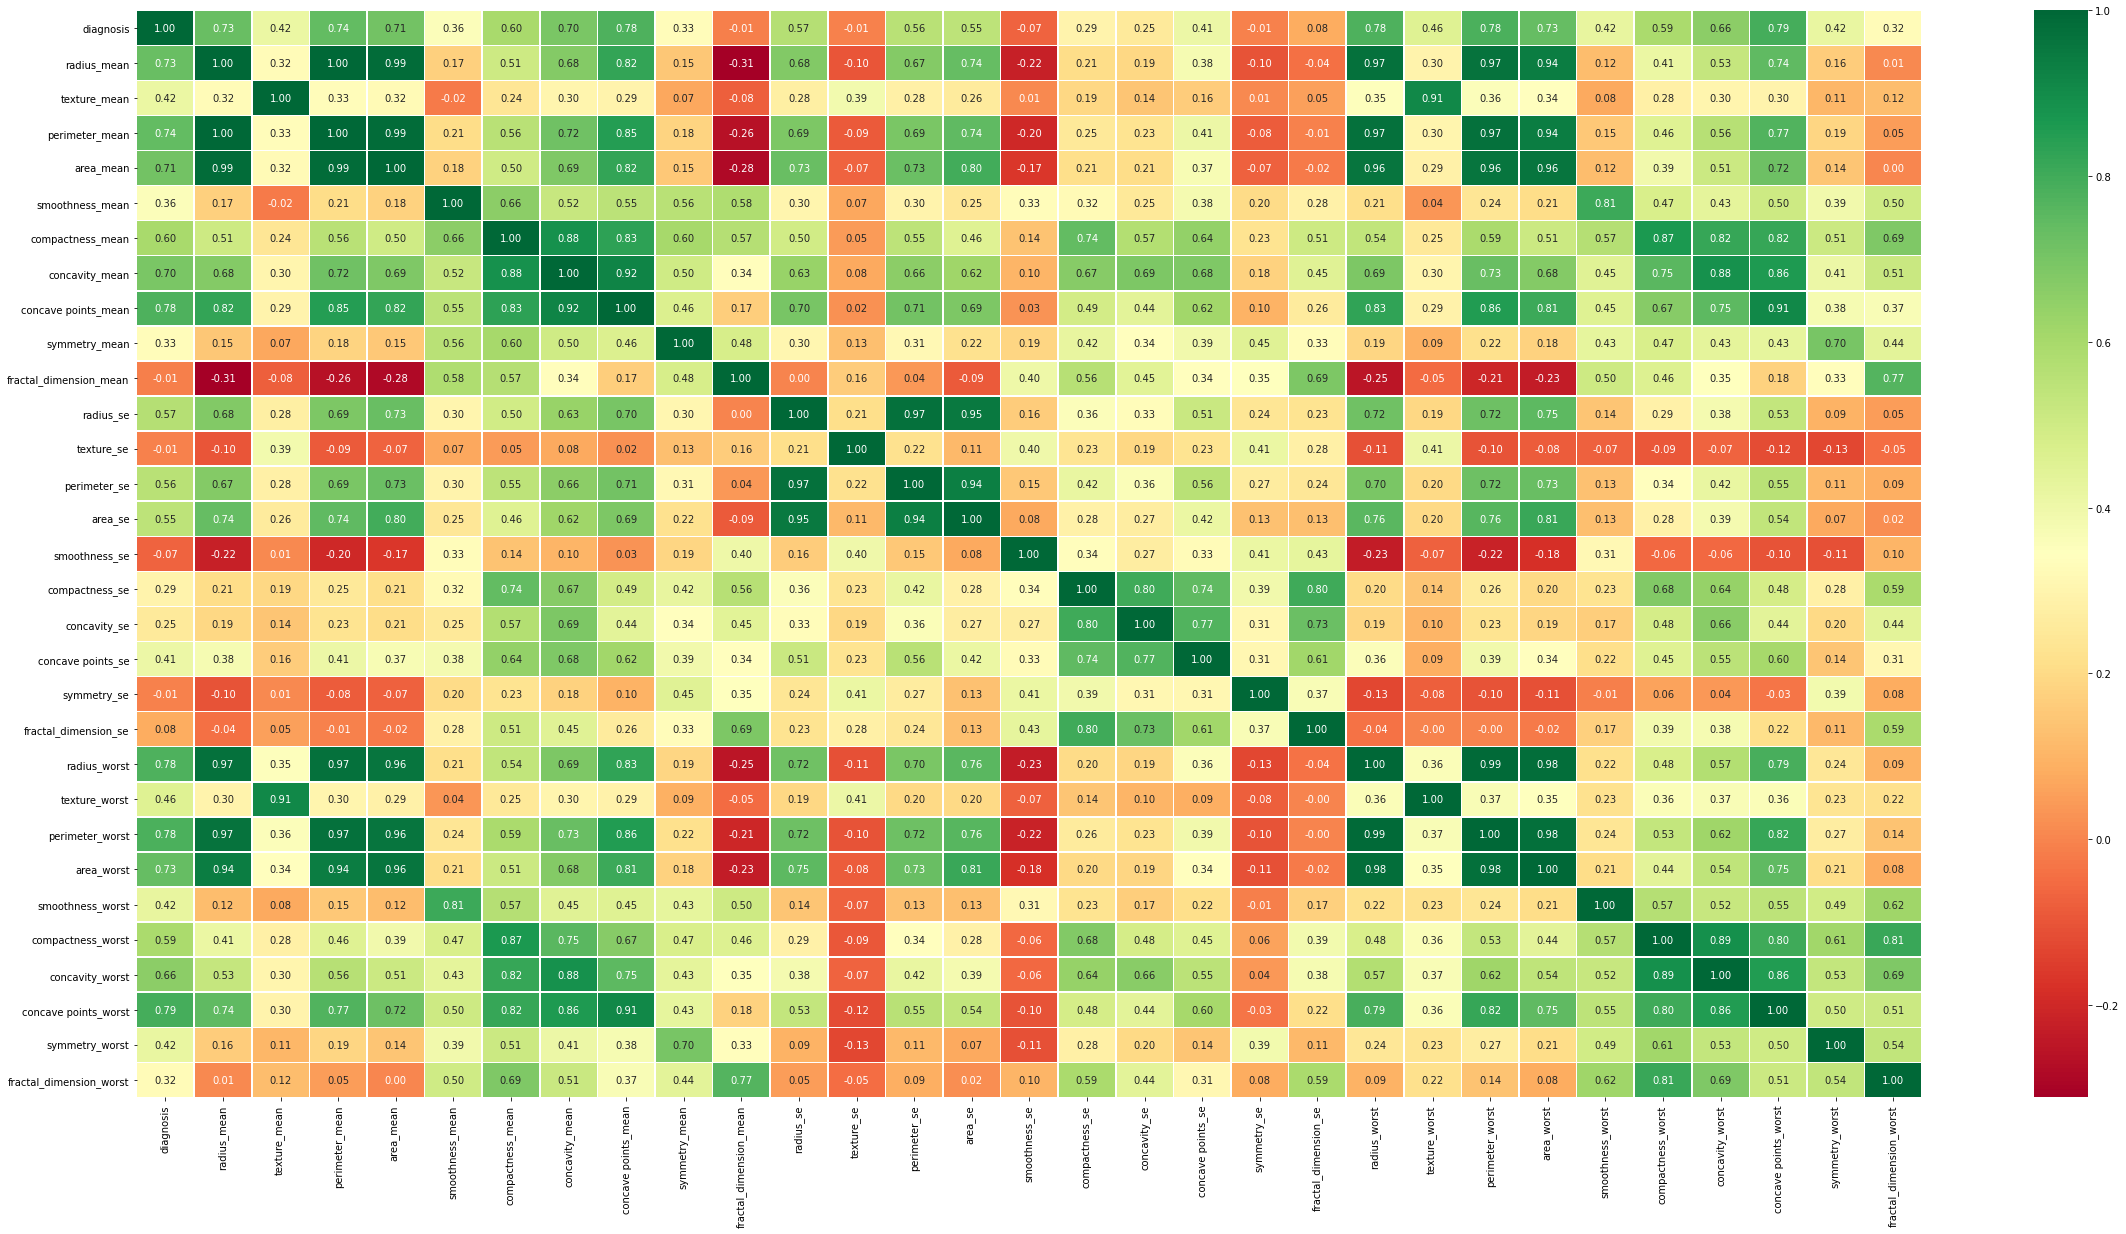

In [16]:
corr = compute_correlation_matrix(df_raw.drop(*['id']))

sns.heatmap(
    data=corr,
    annot=True,
    fmt='.2f',
    linewidths=.5,
    cmap='RdYlGn',
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values
)

fig = plt.gcf()
fig.set_size_inches(40, 20)

plt.show()



In this step we can eliminate some features which are correlated with each other.

*    In the bottom left of the correlation matrix, there is a 10x10 square. X axis is features with 'mean' and the y axis is features with 'worst'. If you look this square carefully, you can see there is a diagonal (top-left to bottom-right) with 1 correlation. This means features with 'mean' and 'worst' are positively correlated. So we may consider using only 1 of the features. (For example, check radius_mean and radius_worst) But if we choose to drop all features with 'worst' we can lose some information for dataset. In that case we can drop some of the features from both.

*    radius_mean, area_mean and perimeter_mean are correlated. I will use perimeter_mean.
*    compactness_mean, concavity_mean, concave_points_mean are correlated. I will use concave_points_mean.
*    radius_se, area_se and perimeter_se are correlated. I will use radius_se

In [0]:
drop_list = ["texture_worst", "smoothness_worst", "compactness_worst", 
             "concavity_worst", "symmetry_worst", "fractal_dimension_worst",
             "radius_mean", "area_mean", "compactness_mean", "concavity_mean", 
             "area_se", "perimeter_se"]

In [18]:
df_reduced = df_raw.drop(*drop_list)
df_reduced.printSchema()

root
 |-- id: string (nullable = true)
 |-- diagnosis: float (nullable = true)
 |-- texture_mean: float (nullable = true)
 |-- perimeter_mean: float (nullable = true)
 |-- smoothness_mean: float (nullable = true)
 |-- concave points_mean: float (nullable = true)
 |-- symmetry_mean: float (nullable = true)
 |-- fractal_dimension_mean: float (nullable = true)
 |-- radius_se: float (nullable = true)
 |-- texture_se: float (nullable = true)
 |-- smoothness_se: float (nullable = true)
 |-- compactness_se: float (nullable = true)
 |-- concavity_se: float (nullable = true)
 |-- concave points_se: float (nullable = true)
 |-- symmetry_se: float (nullable = true)
 |-- fractal_dimension_se: float (nullable = true)
 |-- radius_worst: float (nullable = true)
 |-- perimeter_worst: float (nullable = true)
 |-- area_worst: float (nullable = true)
 |-- concave points_worst: float (nullable = true)



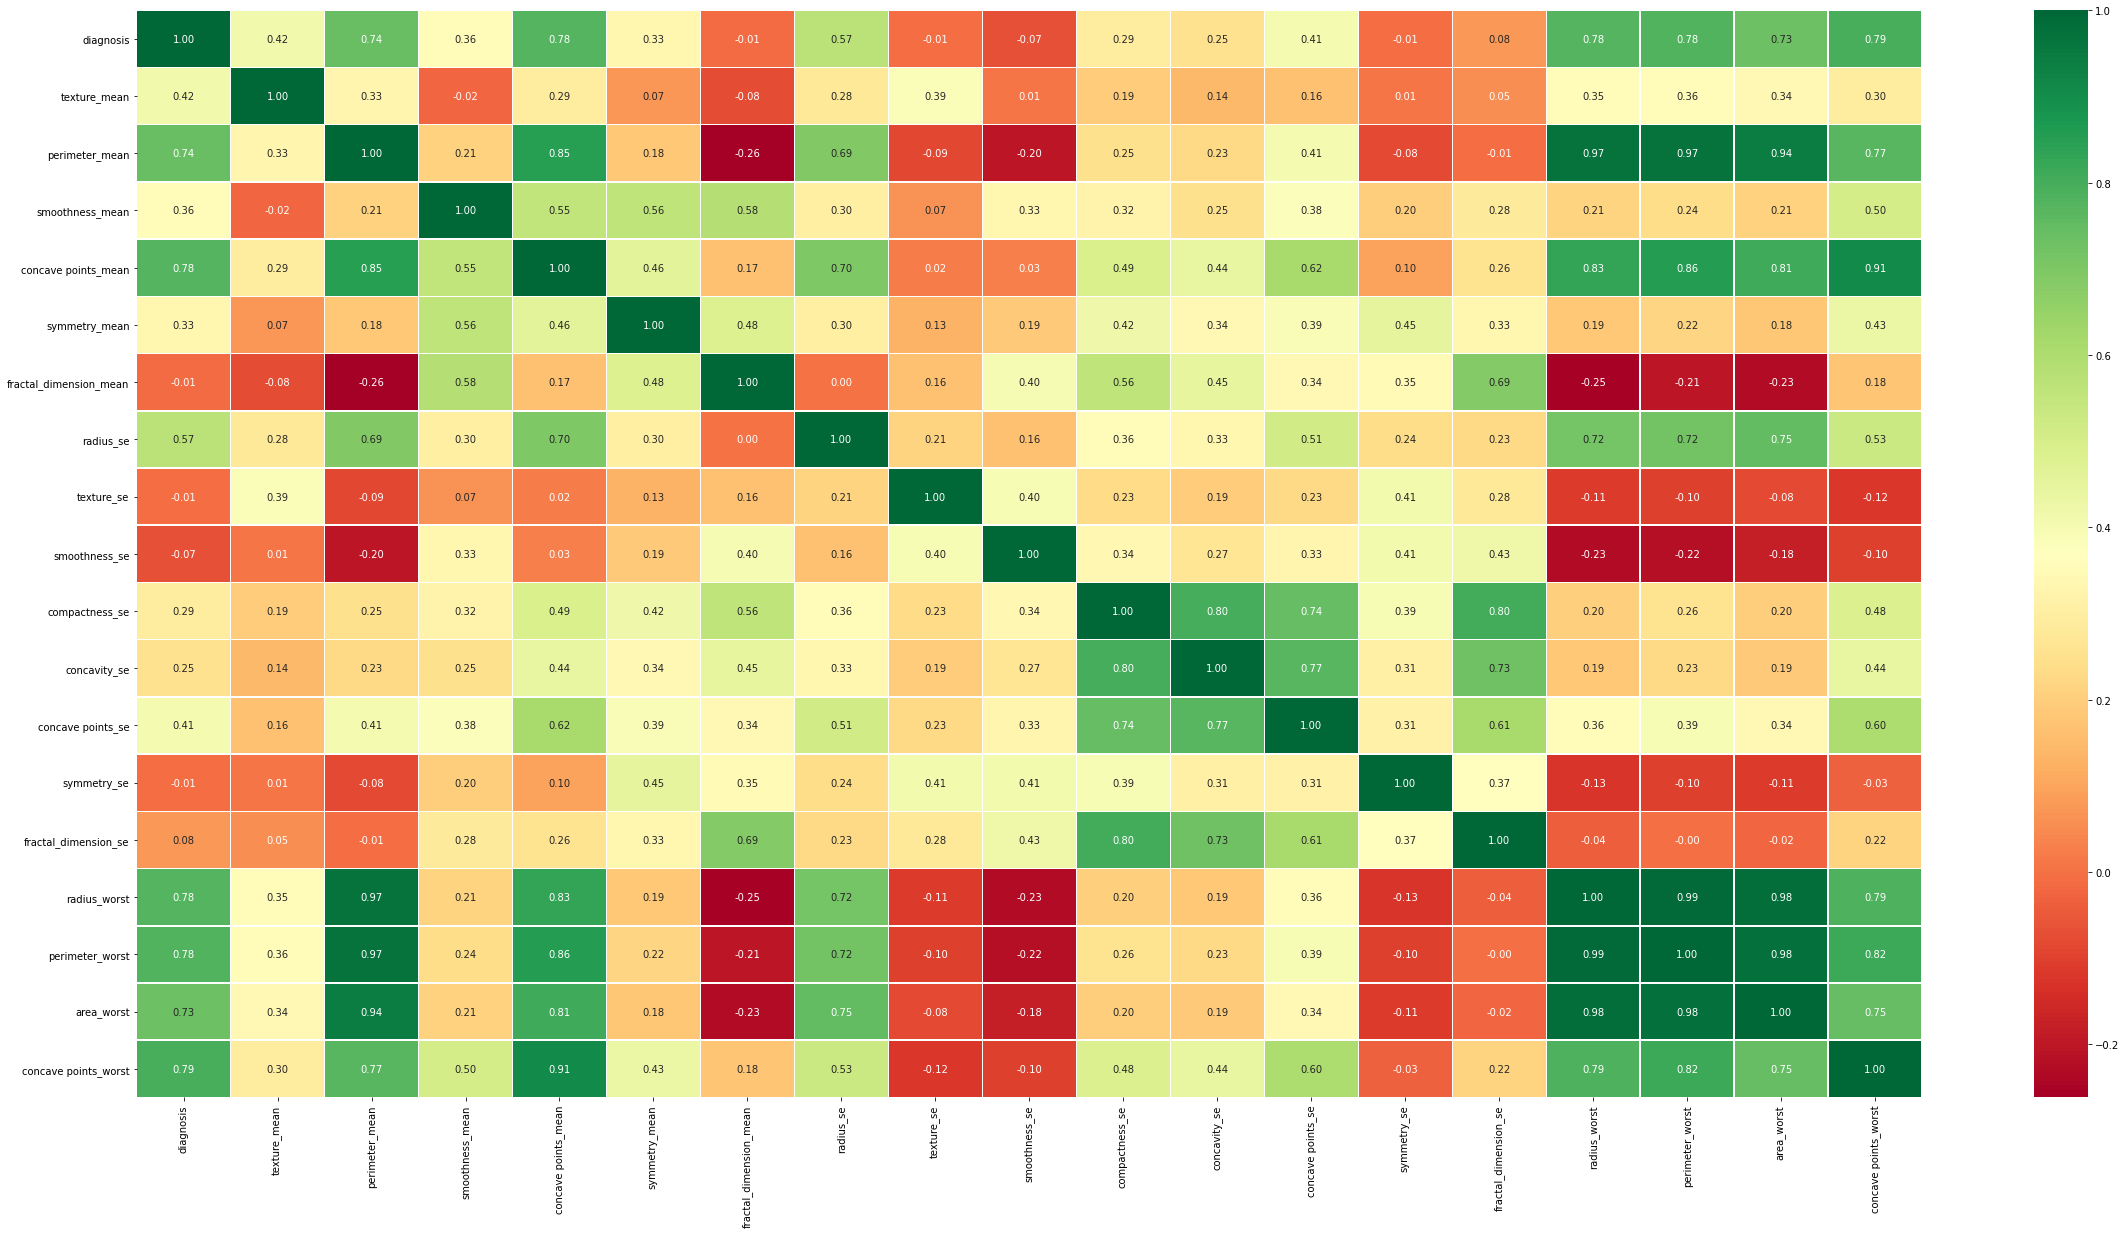

In [19]:
corr = compute_correlation_matrix(df_reduced.drop(*['id']))

sns.heatmap(
    data=corr,
    annot=True,
    fmt='.2f',
    linewidths=.5,
    cmap='RdYlGn',
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values
)

fig = plt.gcf()
fig.set_size_inches(40, 20)

plt.show()

## Modeling for Clustering <a class="anchor" id="clusteringmodel"></a>

In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml import Pipeline

inputcols = list(set(df_raw.columns) - {'diagnosis', 'id'})
reduced_inputcols = list(set(df_reduced.columns) - {'diagnosis', 'id'})


assembler = VectorAssembler(inputCols=inputcols, outputCol="features")

# Min-Max Normalizing
scaler = MinMaxScaler(inputCol="features", outputCol="n_features")

pipeline = Pipeline(stages=[assembler, scaler])
scalerModel = pipeline.fit(df_raw)
scaledData = scalerModel.transform(df_raw).select('id', 'features', 'n_features')

The spark dataframe needs to have a vectors that includes features that will be used in machine learning algorithms. Also for the comparison we created a normalized feature vector in the dataframe. We will compare results of normalized features and not normalized features.

In [0]:
# Reduced Dataset

assembler = VectorAssembler(inputCols=reduced_inputcols, outputCol="features")

# Min-Max Normalizing
scaler = MinMaxScaler(inputCol="features", outputCol="n_features")

pipeline = Pipeline(stages=[assembler, scaler])
scalerModel = pipeline.fit(df_reduced)
reducedData = scalerModel.transform(df_reduced).select('id', 'features', 'n_features')

With the feature selection, there is another dataframe with reduced columns. We apply the same pipeline to this dataset and we will compare the results after.

## Clustering results<a class="anchor" id="clustering"></a>

In [0]:
from pyspark.ml.clustering import KMeans

#### Full Features

In [0]:
k = 2
# Original Dataset
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(scaledData)

# Normalized Dataset
n_kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("n_features")
n_model = n_kmeans.fit(scaledData)

In [24]:
transformed = model.transform(scaledData).select('id', 'prediction')
rows = transformed.collect()

df_pred = sqlContext.createDataFrame(rows)
df_pred.show()

+--------+----------+
|      id|prediction|
+--------+----------+
|  842302|         0|
|  842517|         0|
|84300903|         0|
|84348301|         1|
|84358402|         0|
|  843786|         1|
|  844359|         0|
|84458202|         1|
|  844981|         1|
|84501001|         1|
|  845636|         1|
|84610002|         0|
|  846226|         0|
|  846381|         1|
|84667401|         1|
|84799002|         1|
|  848406|         1|
|84862001|         0|
|  849014|         0|
| 8510426|         1|
+--------+----------+
only showing top 20 rows



In [25]:
n_transformed = n_model.transform(scaledData).select('id', 'prediction')
n_rows = n_transformed.collect()

df_n_pred = sqlContext.createDataFrame(n_rows)
df_n_pred.show()

+--------+----------+
|      id|prediction|
+--------+----------+
|  842302|         0|
|  842517|         0|
|84300903|         0|
|84348301|         0|
|84358402|         0|
|  843786|         0|
|  844359|         0|
|84458202|         0|
|  844981|         0|
|84501001|         0|
|  845636|         1|
|84610002|         0|
|  846226|         0|
|  846381|         1|
|84667401|         0|
|84799002|         0|
|  848406|         1|
|84862001|         0|
|  849014|         0|
| 8510426|         1|
+--------+----------+
only showing top 20 rows



In [26]:
df_pred = df_pred.join(df_raw, 'id')
df_n_pred = df_n_pred.join(df_raw, 'id')
df_pred.show()

+--------+----------+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+
|      id|prediction|diagnosis|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave points_worst|symmetry_worst|fractal_dimension_worst|
+--------+----------+-----

In [27]:
pddf_pred = df_pred.toPandas().set_index('id')
pddf_pred.head()

,prediction,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
842302,0,1.0,17.990000,10.380000,122.800003,1001.000000,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.399994,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.379999,17.330000,184.600006,2019.000000,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,0,1.0,20.570000,17.770000,132.899994,1326.000000,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.080002,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990000,23.410000,158.800003,1956.000000,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,0,1.0,19.690001,21.250000,130.000000,1203.000000,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.029999,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570000,25.530001,152.500000,1709.000000,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,1,1.0,11.420000,20.379999,77.580002,386.100006,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.230000,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910000,26.500000,98.870003,567.700012,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,0,1.0,20.290001,14.340000,135.100006,1297.000000,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.440002,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540001,16.670000,152.199997,1575.000000,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [28]:
pddf_n_pred = df_n_pred.toPandas().set_index('id')
pddf_n_pred.head()

,prediction,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
842302,0,1.0,17.990000,10.380000,122.800003,1001.000000,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.399994,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.379999,17.330000,184.600006,2019.000000,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,0,1.0,20.570000,17.770000,132.899994,1326.000000,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.080002,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990000,23.410000,158.800003,1956.000000,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,0,1.0,19.690001,21.250000,130.000000,1203.000000,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.029999,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570000,25.530001,152.500000,1709.000000,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,0,1.0,11.420000,20.379999,77.580002,386.100006,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.230000,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910000,26.500000,98.870003,567.700012,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,0,1.0,20.290001,14.340000,135.100006,1297.000000,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.440002,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540001,16.670000,152.199997,1575.000000,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [29]:
print("Accuracy for kmeans on original Data: %.4f" % (pddf_pred.prediction != pddf_pred.diagnosis).mean())
print("Accuracy for kmeans on normalized Data: %.4f" % (pddf_n_pred.prediction != pddf_n_pred.diagnosis).mean())

Accuracy for kmeans on original Data: 0.8541
Accuracy for kmeans on normalized Data: 0.9279


#### Reduced Data 

In [0]:
k = 2
# Original Dataset
r_kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
r_model = r_kmeans.fit(reducedData)

# Normalized Dataset
nr_kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("n_features")
nr_model = nr_kmeans.fit(reducedData)

In [31]:
r_transformed = r_model.transform(reducedData).select('id', 'prediction')
r_rows = transformed.collect()

df_r_pred = sqlContext.createDataFrame(r_rows)
df_r_pred.show()

+--------+----------+
|      id|prediction|
+--------+----------+
|  842302|         0|
|  842517|         0|
|84300903|         0|
|84348301|         1|
|84358402|         0|
|  843786|         1|
|  844359|         0|
|84458202|         1|
|  844981|         1|
|84501001|         1|
|  845636|         1|
|84610002|         0|
|  846226|         0|
|  846381|         1|
|84667401|         1|
|84799002|         1|
|  848406|         1|
|84862001|         0|
|  849014|         0|
| 8510426|         1|
+--------+----------+
only showing top 20 rows



In [32]:
nr_transformed = nr_model.transform(reducedData).select('id', 'prediction')
nr_rows = nr_transformed.collect()

df_nr_pred = sqlContext.createDataFrame(nr_rows)
df_nr_pred.show()

+--------+----------+
|      id|prediction|
+--------+----------+
|  842302|         0|
|  842517|         0|
|84300903|         0|
|84348301|         0|
|84358402|         0|
|  843786|         0|
|  844359|         0|
|84458202|         0|
|  844981|         0|
|84501001|         0|
|  845636|         1|
|84610002|         0|
|  846226|         0|
|  846381|         1|
|84667401|         0|
|84799002|         0|
|  848406|         0|
|84862001|         0|
|  849014|         0|
| 8510426|         1|
+--------+----------+
only showing top 20 rows



In [33]:
df_r_pred = df_r_pred.join(df_raw, 'id')
df_nr_pred = df_nr_pred.join(df_raw, 'id')
df_r_pred.show()

+--------+----------+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+
|      id|prediction|diagnosis|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave points_worst|symmetry_worst|fractal_dimension_worst|
+--------+----------+-----

In [34]:
pddf_r_pred = df_r_pred.toPandas().set_index('id')
pddf_r_pred.head()

,prediction,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
842302,0,1.0,17.990000,10.380000,122.800003,1001.000000,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.399994,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.379999,17.330000,184.600006,2019.000000,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,0,1.0,20.570000,17.770000,132.899994,1326.000000,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.080002,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990000,23.410000,158.800003,1956.000000,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,0,1.0,19.690001,21.250000,130.000000,1203.000000,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.029999,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570000,25.530001,152.500000,1709.000000,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,1,1.0,11.420000,20.379999,77.580002,386.100006,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.230000,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910000,26.500000,98.870003,567.700012,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,0,1.0,20.290001,14.340000,135.100006,1297.000000,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.440002,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540001,16.670000,152.199997,1575.000000,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [35]:
pddf_nr_pred = df_nr_pred.toPandas().set_index('id')
pddf_nr_pred.head()

,prediction,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
842302,0,1.0,17.990000,10.380000,122.800003,1001.000000,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.399994,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.379999,17.330000,184.600006,2019.000000,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,0,1.0,20.570000,17.770000,132.899994,1326.000000,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.080002,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990000,23.410000,158.800003,1956.000000,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,0,1.0,19.690001,21.250000,130.000000,1203.000000,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.029999,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570000,25.530001,152.500000,1709.000000,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,0,1.0,11.420000,20.379999,77.580002,386.100006,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.230000,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910000,26.500000,98.870003,567.700012,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,0,1.0,20.290001,14.340000,135.100006,1297.000000,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.440002,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540001,16.670000,152.199997,1575.000000,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [36]:
print("Accuracy for kmeans on original Data: %.4f" % (pddf_r_pred.prediction != pddf_r_pred.diagnosis).mean())
print("Accuracy for kmeans on normalized Data: %.4f" % (pddf_nr_pred.prediction != pddf_nr_pred.diagnosis).mean())

Accuracy for kmeans on original Data: 0.8541
Accuracy for kmeans on normalized Data: 0.9402


#### Conclusion

In [37]:
r_original = (pddf_pred.prediction != pddf_pred.diagnosis).mean()
r_norm = (pddf_n_pred.prediction != pddf_n_pred.diagnosis).mean()
r_reduced = (pddf_r_pred.prediction != pddf_r_pred.diagnosis).mean()
r_reduced_norm = (pddf_nr_pred.prediction != pddf_nr_pred.diagnosis).mean()

clustering_results = {
    
    "Original": {
                'model': 'Original',
                'accuracy': r_original
                },
    "Normalized": {
                'model': 'Normalized',
                'accuracy': r_norm
                },
    "Reduced": {
                'model': 'Reduced',
                'accuracy': r_reduced
                },
    "Reduced+Normalized": {
                'model': 'Reduced+Normalized',
                'accuracy': r_reduced_norm
                }
}

clustering_results = pd.DataFrame.from_dict(clustering_results).transpose()
clustering_results.head()

,model,accuracy
Original,Original,0.85413
Normalized,Normalized,0.927944
Reduced,Reduced,0.85413
Reduced+Normalized,Reduced+Normalized,0.940246


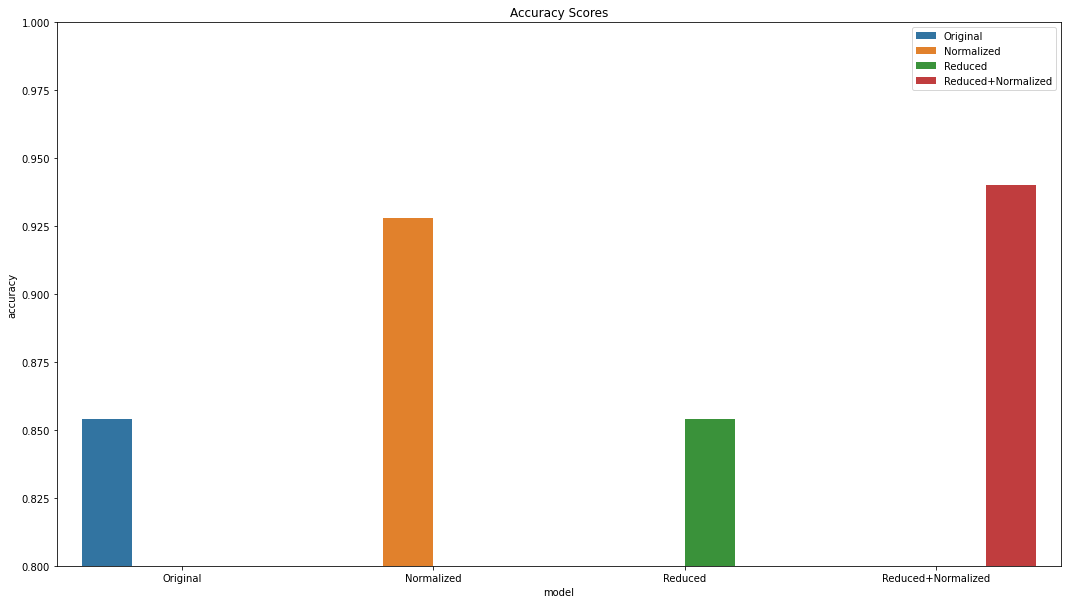

In [38]:
plt.figure(figsize=(18,10))
g=sns.barplot(x='model', y='accuracy', hue='model', data=clustering_results)
g.axes.set_ylim(0.8,1)
sns.set_style({'axes.grid' : True})
plt.title("Accuracy Scores")
plt.legend(loc='best')
plt.show()

As we see in this graph, all models has more than 85% accuracy. But the most accurate model was reduced and normalized model. For all datasets, we see the model trained with normalized data are more accurate than the others. And the other observation is that the reducing (feature selection) effected clustering models in a positive way. 
In overall, the best results achieved with the model trained with reduced and normalized dataset. The accuracy is 94.02% for this model. 


## Modeling for Classification <a class="anchor" id="classificationmodel"></a>

In [44]:
print("Original Dataset")
train_data, test_data = df_raw.randomSplit([0.8, 0.2])
print("Train Data Shape: (%d, %d)"%(train_data.count(), len(train_data.columns)))
print("Test Data Shape: (%d, %d)"%(test_data.count(), len(test_data.columns)))

print("Reduced Dataset")
rtrain_data, rtest_data = df_reduced.randomSplit([0.8, 0.2])
print("Train Data Shape: (%d, %d)"%(rtrain_data.count(), len(rtrain_data.columns)))
print("Test Data Shape: (%d, %d)"%(rtest_data.count(), len(rtest_data.columns)))

Original Dataset
Train Data Shape: (456, 32)
Test Data Shape: (113, 32)
Reduced Dataset
Train Data Shape: (458, 20)
Test Data Shape: (111, 20)


In [0]:
# Original Dataset

assembler = VectorAssembler(inputCols=inputcols, outputCol="features")

# Min-Max Normalizing
scaler = MinMaxScaler(inputCol="features", outputCol="n_features")

pipeline = Pipeline(stages=[assembler, scaler])

X_train_data = pipeline.fit(train_data)
X_train = X_train_data.transform(train_data).select('id', 'diagnosis', 'features', 'n_features')

X_test_data = pipeline.fit(test_data)
X_test = X_test_data.transform(test_data).select('id', 'diagnosis', 'features', 'n_features')

In [0]:
# Reduced Dataset

assembler = VectorAssembler(inputCols=reduced_inputcols, outputCol="features")

# Min-Max Normalizing
scaler = MinMaxScaler(inputCol="features", outputCol="n_features")

pipeline = Pipeline(stages=[assembler, scaler])

Xr_train_data = pipeline.fit(rtrain_data)
Xr_train = Xr_train_data.transform(rtrain_data).select('id', 'diagnosis', 'features', 'n_features')

Xr_test_data = pipeline.fit(rtest_data)
Xr_test = Xr_test_data.transform(rtest_data).select('id', 'diagnosis', 'features', 'n_features')

I will use logistic regression. The reason for using logistic regression is my past experience with that model. On assignment 2, with the same dataset I performed train and tests on several models. And the logistic regression was the most stable and accurate model. 

Because of the working principals of logistic regression, it is a very good model for binary classification tasks. With the dynamic threshold (the threshold used for splitting data based on class probabilities) logistic regression can split binary classes with minimal errors.

## Evaluation<a class="anchor" id="evaluation"></a>

### Original Dataset

In [0]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol='features', labelCol='diagnosis')
lrmodel = lr.fit(X_train)

In [0]:
n_lr = LogisticRegression(featuresCol='n_features', labelCol='diagnosis')
n_lrmodel = n_lr.fit(X_train)

#### Not normalized features

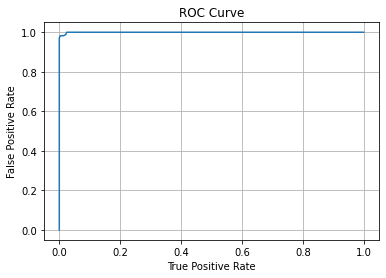

Training set areaUnderROC: 0.9996101364522417


In [71]:
trainingSummary = lrmodel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

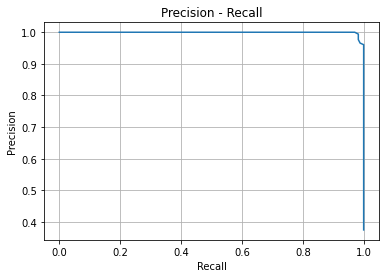

In [98]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title("Precision - Recall")
plt.show()

In [85]:
predictions = lrmodel.transform(X_test)
predictions.select('id', 'probability', 'prediction').show(10)

+-------+--------------------+----------+
|     id|         probability|prediction|
+-------+--------------------+----------+
| 842302|[2.61013920584482...|       1.0|
| 843786|[3.80849401808032...|       1.0|
| 845636|[8.72611086879360...|       1.0|
|8510653|[1.0,2.9093415709...|       0.0|
|8511133|[1.59556206537896...|       1.0|
| 852552|[2.11183354277838...|       1.0|
| 853401|[2.40653664654523...|       1.0|
| 854039|[1.73382075133038...|       1.0|
| 855625|[2.83825646402437...|       1.0|
| 856106|[1.23241521962419...|       1.0|
+-------+--------------------+----------+
only showing top 10 rows



In [88]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol='diagnosis')
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.9932249322493225


In [91]:
df_pred = predictions.select('id', 'prediction').join(df_raw, 'id')
pddf_pred = df_pred.toPandas().set_index('id')
pddf_pred.head()

,prediction,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
842302,1.0,1.0,17.99,10.38,122.800003,1001.000000,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.399994,0.006399,0.049040,0.05373,0.015870,0.03003,0.006193,25.379999,17.330000,184.600006,2019.000000,0.1622,0.6656,0.7119,0.26540,0.4601,0.11890
843786,1.0,1.0,12.45,15.70,82.570000,477.100006,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,0.3345,0.8902,2.217,27.190001,0.007510,0.033450,0.03672,0.011370,0.02165,0.005082,15.470000,23.750000,103.400002,741.599976,0.1791,0.5249,0.5355,0.17410,0.3985,0.12440
845636,1.0,1.0,16.02,23.24,102.699997,797.799988,0.08206,0.06669,0.03299,0.03323,0.1528,0.05697,0.3795,1.1870,2.466,40.509998,0.004029,0.009269,0.01101,0.007591,0.01460,0.003042,19.190001,33.880001,123.800003,1150.000000,0.1181,0.1551,0.1459,0.09975,0.2948,0.08452
8510653,0.0,0.0,13.08,15.71,85.629997,520.000000,0.10750,0.12700,0.04568,0.03110,0.1967,0.06811,0.1852,0.7477,1.383,14.670000,0.004097,0.018980,0.01698,0.006490,0.01678,0.002425,14.500000,20.490000,96.089996,630.500000,0.1312,0.2776,0.1890,0.07283,0.3184,0.08183
8511133,1.0,1.0,15.34,14.26,102.500000,704.400024,0.10730,0.21350,0.20770,0.09756,0.2521,0.07032,0.4388,0.7096,3.384,44.910000,0.006789,0.053280,0.06446,0.022520,0.03672,0.004394,18.070000,19.080000,125.099998,980.900024,0.1390,0.5954,0.6305,0.23930,0.4667,0.09946


In [0]:
from sklearn.metrics import classification_report,f1_score,accuracy_score,confusion_matrix

def classification_results(y_true, y_pred):
    print('Accuracy of the classifier on test set: {:.4f}'.format(accuracy_score(y_true, y_pred)))
    print(classification_report(y_true, y_pred))
        
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True)
    plt.show()

Accuracy of the classifier on test set: 0.9469
              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96        72
         1.0       0.89      0.98      0.93        41

    accuracy                           0.95       113
   macro avg       0.94      0.95      0.94       113
weighted avg       0.95      0.95      0.95       113



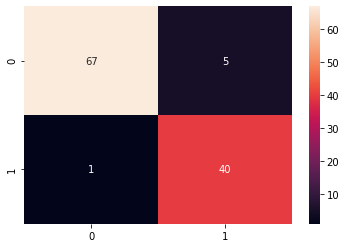

In [97]:
classification_results(pddf_pred.diagnosis, pddf_pred.prediction)

#### Normalized Features

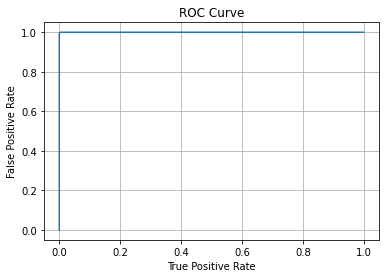

Training set areaUnderROC: 0.9999897404329537


In [101]:
trainingSummary = n_lrmodel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

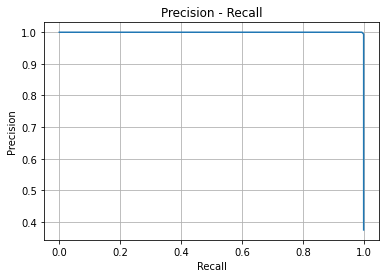

In [102]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title("Precision - Recall")
plt.show()

In [104]:
n_predictions = n_lrmodel.transform(X_test)
n_predictions.select('id', 'probability', 'prediction').show(10)

+-------+--------------------+----------+
|     id|         probability|prediction|
+-------+--------------------+----------+
| 842302|           [0.0,1.0]|       1.0|
| 843786|           [0.0,1.0]|       1.0|
| 845636|           [0.0,1.0]|       1.0|
|8510653|[0.67838716596735...|       0.0|
|8511133|           [0.0,1.0]|       1.0|
| 852552|           [0.0,1.0]|       1.0|
| 853401|           [0.0,1.0]|       1.0|
| 854039|           [0.0,1.0]|       1.0|
| 855625|           [0.0,1.0]|       1.0|
| 856106|           [0.0,1.0]|       1.0|
+-------+--------------------+----------+
only showing top 10 rows



In [105]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol='diagnosis')
print('Test Area Under ROC', evaluator.evaluate(n_predictions))

Test Area Under ROC 0.9908536585365855


In [106]:
df_n_pred = n_predictions.select('id', 'prediction').join(df_raw, 'id')
pddf_n_pred = df_n_pred.toPandas().set_index('id')
pddf_n_pred.head()

,prediction,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
842302,1.0,1.0,17.99,10.38,122.800003,1001.000000,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.399994,0.006399,0.049040,0.05373,0.015870,0.03003,0.006193,25.379999,17.330000,184.600006,2019.000000,0.1622,0.6656,0.7119,0.26540,0.4601,0.11890
843786,1.0,1.0,12.45,15.70,82.570000,477.100006,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,0.3345,0.8902,2.217,27.190001,0.007510,0.033450,0.03672,0.011370,0.02165,0.005082,15.470000,23.750000,103.400002,741.599976,0.1791,0.5249,0.5355,0.17410,0.3985,0.12440
845636,1.0,1.0,16.02,23.24,102.699997,797.799988,0.08206,0.06669,0.03299,0.03323,0.1528,0.05697,0.3795,1.1870,2.466,40.509998,0.004029,0.009269,0.01101,0.007591,0.01460,0.003042,19.190001,33.880001,123.800003,1150.000000,0.1181,0.1551,0.1459,0.09975,0.2948,0.08452
8510653,0.0,0.0,13.08,15.71,85.629997,520.000000,0.10750,0.12700,0.04568,0.03110,0.1967,0.06811,0.1852,0.7477,1.383,14.670000,0.004097,0.018980,0.01698,0.006490,0.01678,0.002425,14.500000,20.490000,96.089996,630.500000,0.1312,0.2776,0.1890,0.07283,0.3184,0.08183
8511133,1.0,1.0,15.34,14.26,102.500000,704.400024,0.10730,0.21350,0.20770,0.09756,0.2521,0.07032,0.4388,0.7096,3.384,44.910000,0.006789,0.053280,0.06446,0.022520,0.03672,0.004394,18.070000,19.080000,125.099998,980.900024,0.1390,0.5954,0.6305,0.23930,0.4667,0.09946


Accuracy of the classifier on test set: 0.5841
              precision    recall  f1-score   support

         0.0       1.00      0.35      0.52        72
         1.0       0.47      1.00      0.64        41

    accuracy                           0.58       113
   macro avg       0.73      0.67      0.58       113
weighted avg       0.81      0.58      0.56       113



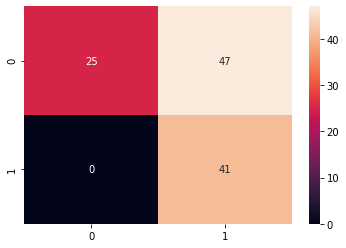

In [107]:
classification_results(pddf_n_pred.diagnosis, pddf_n_pred.prediction)

### Reduced Data

In [0]:
r_lr = LogisticRegression(featuresCol='features', labelCol='diagnosis')
r_lrmodel = r_lr.fit(Xr_train)

In [0]:
nr_lr = LogisticRegression(featuresCol='n_features', labelCol='diagnosis')
nr_lrmodel = nr_lr.fit(Xr_train)

#### Not Normalized Features

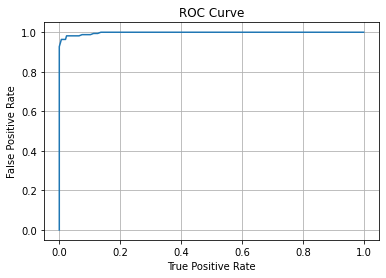

Training set areaUnderROC: 0.997600579170545


In [112]:
trainingSummary = r_lrmodel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

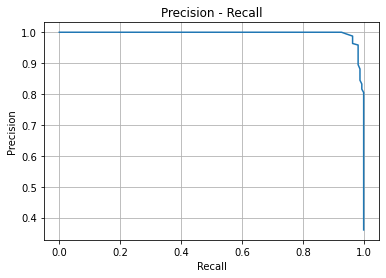

In [113]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title("Precision - Recall")
plt.show()

In [114]:
r_predictions = r_lrmodel.transform(Xr_test)
r_predictions.select('id', 'probability', 'prediction').show(10)

+--------+--------------------+----------+
|      id|         probability|prediction|
+--------+--------------------+----------+
|  842517|[2.87125840842959...|       1.0|
|  843786|[4.44926117431057...|       1.0|
|  845636|[9.38380557297855...|       1.0|
|84667401|[0.00903667370054...|       1.0|
|  851509|[3.01131286199548...|       1.0|
|  852552|[2.73912054415958...|       1.0|
|  853401|[3.56828670252583...|       1.0|
|  853612|[1.19474575186048...|       1.0|
|  854268|[0.08185767103390...|       1.0|
|  854941|[0.99999971976138...|       0.0|
+--------+--------------------+----------+
only showing top 10 rows



In [115]:
evaluator = BinaryClassificationEvaluator(labelCol='diagnosis')
print('Test Area Under ROC', evaluator.evaluate(r_predictions))

Test Area Under ROC 0.9960106382978724


In [116]:
df_r_pred = r_predictions.select('id', 'prediction').join(df_raw, 'id')
pddf_r_pred = df_r_pred.toPandas().set_index('id')
pddf_r_pred.head()

,prediction,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
842517,1.0,1.0,20.57,17.770000,132.899994,1326.000000,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.080002,0.005225,0.013080,0.01860,0.013400,0.01389,0.003532,24.990000,23.410000,158.800003,1956.000000,0.1238,0.1866,0.2416,0.18600,0.2750,0.08902
843786,1.0,1.0,12.45,15.700000,82.570000,477.100006,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,0.3345,0.8902,2.217,27.190001,0.007510,0.033450,0.03672,0.011370,0.02165,0.005082,15.470000,23.750000,103.400002,741.599976,0.1791,0.5249,0.5355,0.17410,0.3985,0.12440
845636,1.0,1.0,16.02,23.240000,102.699997,797.799988,0.08206,0.06669,0.03299,0.03323,0.1528,0.05697,0.3795,1.1870,2.466,40.509998,0.004029,0.009269,0.01101,0.007591,0.01460,0.003042,19.190001,33.880001,123.800003,1150.000000,0.1181,0.1551,0.1459,0.09975,0.2948,0.08452
84667401,1.0,1.0,13.73,22.610001,93.599998,578.299988,0.11310,0.22930,0.21280,0.08025,0.2069,0.07682,0.2121,1.1690,2.061,19.209999,0.006429,0.059360,0.05501,0.016280,0.01961,0.008093,15.030000,32.009998,108.800003,697.700012,0.1651,0.7725,0.6943,0.22080,0.3596,0.14310
851509,1.0,1.0,21.16,23.040001,137.199997,1404.000000,0.09428,0.10220,0.10970,0.08632,0.1769,0.05278,0.6917,1.1270,4.303,93.989998,0.004728,0.012590,0.01715,0.010380,0.01083,0.001987,29.170000,35.590000,188.000000,2615.000000,0.1401,0.2600,0.3155,0.20090,0.2822,0.07526


Accuracy of the classifier on test set: 0.9640
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97        64
         1.0       0.96      0.96      0.96        47

    accuracy                           0.96       111
   macro avg       0.96      0.96      0.96       111
weighted avg       0.96      0.96      0.96       111



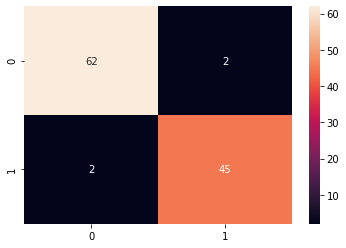

In [117]:
classification_results(pddf_r_pred.diagnosis, pddf_r_pred.prediction)

#### Normalized Features

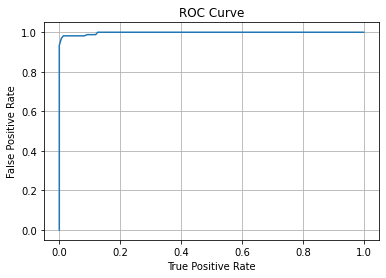

Training set areaUnderROC: 0.9977350294756437


In [118]:
trainingSummary = nr_lrmodel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

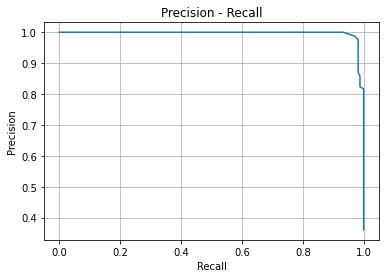

In [119]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title("Precision - Recall")
plt.show()

In [120]:
nr_predictions = nr_lrmodel.transform(Xr_test)
nr_predictions.select('id', 'probability', 'prediction').show(10)

+--------+--------------------+----------+
|      id|         probability|prediction|
+--------+--------------------+----------+
|  842517|[1.56932485112204...|       1.0|
|  843786|[1.42621643801560...|       1.0|
|  845636|[0.11709012195567...|       1.0|
|84667401|[0.00107839832922...|       1.0|
|  851509|[4.34700998864665...|       1.0|
|  852552|[3.45633878728203...|       1.0|
|  853401|[2.25469382355336...|       1.0|
|  853612|[4.72907780068212...|       1.0|
|  854268|[0.47481356281175...|       1.0|
|  854941|[0.99999998372469...|       0.0|
+--------+--------------------+----------+
only showing top 10 rows



In [121]:
evaluator = BinaryClassificationEvaluator(labelCol='diagnosis')
print('Test Area Under ROC', evaluator.evaluate(nr_predictions))

Test Area Under ROC 0.9837101063829788


In [122]:
df_nr_pred = nr_predictions.select('id', 'prediction').join(df_raw, 'id')
pddf_nr_pred = df_nr_pred.toPandas().set_index('id')
pddf_nr_pred.head()

,prediction,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
842517,1.0,1.0,20.57,17.770000,132.899994,1326.000000,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.080002,0.005225,0.013080,0.01860,0.013400,0.01389,0.003532,24.990000,23.410000,158.800003,1956.000000,0.1238,0.1866,0.2416,0.18600,0.2750,0.08902
843786,1.0,1.0,12.45,15.700000,82.570000,477.100006,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,0.3345,0.8902,2.217,27.190001,0.007510,0.033450,0.03672,0.011370,0.02165,0.005082,15.470000,23.750000,103.400002,741.599976,0.1791,0.5249,0.5355,0.17410,0.3985,0.12440
845636,1.0,1.0,16.02,23.240000,102.699997,797.799988,0.08206,0.06669,0.03299,0.03323,0.1528,0.05697,0.3795,1.1870,2.466,40.509998,0.004029,0.009269,0.01101,0.007591,0.01460,0.003042,19.190001,33.880001,123.800003,1150.000000,0.1181,0.1551,0.1459,0.09975,0.2948,0.08452
84667401,1.0,1.0,13.73,22.610001,93.599998,578.299988,0.11310,0.22930,0.21280,0.08025,0.2069,0.07682,0.2121,1.1690,2.061,19.209999,0.006429,0.059360,0.05501,0.016280,0.01961,0.008093,15.030000,32.009998,108.800003,697.700012,0.1651,0.7725,0.6943,0.22080,0.3596,0.14310
851509,1.0,1.0,21.16,23.040001,137.199997,1404.000000,0.09428,0.10220,0.10970,0.08632,0.1769,0.05278,0.6917,1.1270,4.303,93.989998,0.004728,0.012590,0.01715,0.010380,0.01083,0.001987,29.170000,35.590000,188.000000,2615.000000,0.1401,0.2600,0.3155,0.20090,0.2822,0.07526


Accuracy of the classifier on test set: 0.9459
              precision    recall  f1-score   support

         0.0       0.97      0.94      0.95        64
         1.0       0.92      0.96      0.94        47

    accuracy                           0.95       111
   macro avg       0.94      0.95      0.94       111
weighted avg       0.95      0.95      0.95       111



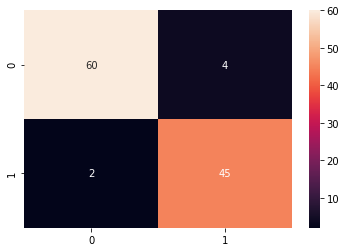

In [123]:
classification_results(pddf_nr_pred.diagnosis, pddf_nr_pred.prediction)

#### Conclusion

In [126]:
r_original = (pddf_pred.prediction == pddf_pred.diagnosis).mean()
r_norm = (pddf_n_pred.prediction == pddf_n_pred.diagnosis).mean()
r_reduced = (pddf_r_pred.prediction == pddf_r_pred.diagnosis).mean()
r_reduced_norm = (pddf_nr_pred.prediction == pddf_nr_pred.diagnosis).mean()

classification_results = {
    
    "Original": {
                'model': 'Original',
                'accuracy': r_original
                },
    "Normalized": {
                'model': 'Normalized',
                'accuracy': r_norm
                },
    "Reduced": {
                'model': 'Reduced',
                'accuracy': r_reduced
                },
    "Reduced+Normalized": {
                'model': 'Reduced+Normalized',
                'accuracy': r_reduced_norm
                }
}

classification_results = pd.DataFrame.from_dict(classification_results).transpose()
classification_results.head()

,model,accuracy
Original,Original,0.946903
Normalized,Normalized,0.584071
Reduced,Reduced,0.963964
Reduced+Normalized,Reduced+Normalized,0.945946


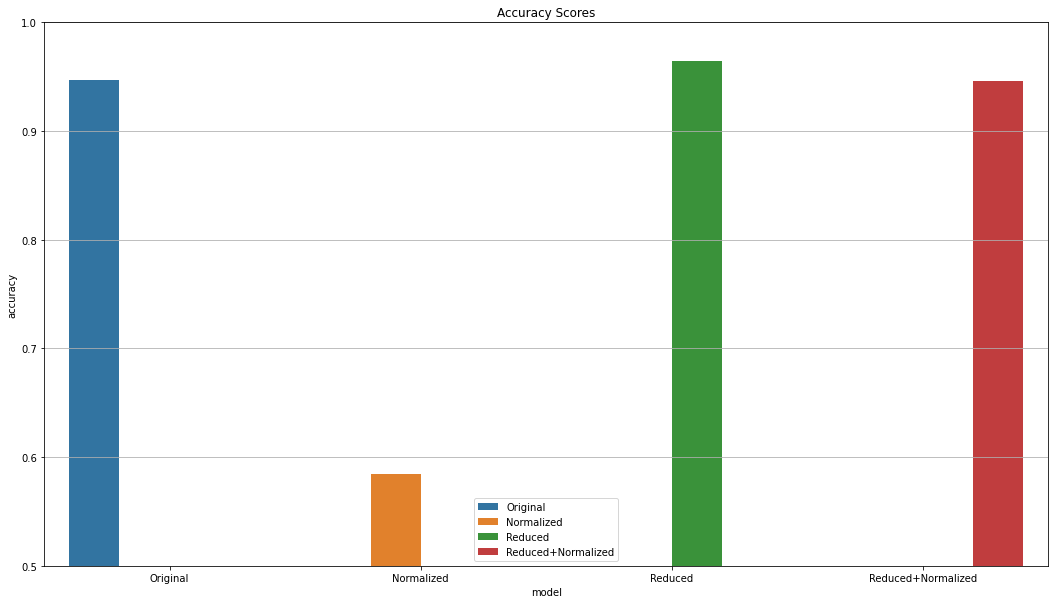

In [128]:
plt.figure(figsize=(18,10))
g=sns.barplot(x='model', y='accuracy', hue='model', data=classification_results)
g.axes.set_ylim(0.5,1)
sns.set_style({'axes.grid' : True})
plt.title("Accuracy Scores")
plt.legend(loc='best')
plt.show()

As we see in this graph, all models except used original and normalized performed very well. In overall we can see that, normalizing did not incresed accuracy on models. In the other hand we can easily see that feature selection increased models' accuracies. For example if we check not normalized original and reduced dataset we observe 2.2% increase in accuracy.

The best combination for all datasets was the model trained with reduced and not normalized data. It has achieved 96.4% accuracy on test data.

## References<a class="anchor" id="references"></a>

Some of the code blocks inspired or used from these notebooks. (If a code block used as it is I placed the link on the code block as a python comment)

1. [Machine Learning with PySpark and MLlib — Solving a Binary Classification 
Problem - by Susan Li (Medium)](https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa)

2. [A Neanderthal’s Guide to Apache Spark in Python - by Evan Heitman (Medium)](https://towardsdatascience.com/a-neanderthals-guide-to-apache-spark-in-python-9ef1f156d427)

3. [Computing Correlation Matrix on Apache Spark](https://forums.databricks.com/questions/3092/how-to-calculate-correlation-matrix-with-all-colum.html)




**Disclaimer!** <font color='grey'>This notebook was prepared by Ali Baran Tasdemir as an assigment for the *BBM469 - Data Intensive Applications Laboratory* class. The notebook is available for educational purposes only. There is no guarantee on the correctness of the content provided as it is a student work.

If you think there is any copyright violation, please let us [know](https://forms.gle/BNNRB2kR8ZHVEREq8). 
</font>